In [1]:
import numpy as np
import mne
import os, sys
import re
import pandas as pd

In [2]:
from snn_lib.neuron_models.leaky_intergrate_and_fire_model import *
from snn_lib.synapse_models.delay_connection import *
from snn_lib.synapse_models.exponential_synapse import *
from snn_lib.neuron_models.point_process_model import *
from snn_lib.connections.full_connection import *
from snn_lib.connections.one_to_one_connection import OneToOneConnection
from snn_lib.neuron_models.fixed_spike_train_neuron_model import FixedSpikeTrainNeuronModel
from snn_lib.monitors.neuron_monitors import NeuronOutputMonitor, NeuronMembranePotentialMonitor
from snn_lib.monitors.synapse_monitors import *
import numpy as np
from microstates.main.eeg_recording import *
from snn_lib.plots.snn_recorder_plot import plot_neuron_record
from snn_lib.connections.custom_connection import CustomConnection, CustomOneToOneConnection, CustomAllToAllConnection

## Load Dataset

In [3]:
eeg_raw = mne.io.read_raw('C:/Users/Micro/Desktop/MainResearchProjects/eeg-language/data/dataset1/Raw_EDF_Files/p10_Record1.edf') #list(eeg_raw.values())[0]

Extracting EDF parameters from C:\Users\Micro\Desktop\MainResearchProjects\eeg-language\data\dataset1\Raw_EDF_Files\p10_Record1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [4]:
SOP = 30 * 60 # seizure occurrance period (s)
SPH = 5 * 60 # seizure prediction horizon

In [5]:
freq = 500
total_length = freq * SOP

In [6]:
data = eeg_raw.get_data().T

In [7]:
# Clip the data. (Extract the seizure occurrance period)

record_start = (5, 36, 39) # hour, minute, seconds.

seizure1 = (7, 36, 38)  # hour, minute, seconds.
seizure1_start = ((seizure1[0] - record_start[0]) * 3600 + (seizure1[1] - record_start[1]) * 60 + (seizure1[2] - record_start[2])) * freq
seizure1_length = (60 * 7 + 25) * freq
seizure1_end = seizure1_start + seizure1_length

# clip
seizure_mid = (seizure1_start + seizure1_end) // 2
clip_left = (seizure_mid - total_length // 2)
clip_right = (seizure_mid + total_length // 2)
additional_offset = 0

# Right moving the fragment, if `clip_left` < 0 (seizure happens < 15 minute from the beginning of record.). 
# This operation aims at making prediction area as large as possible.
if (clip_left < 0):
    max_movable_length = seizure1_end - seizure_mid + (seizure1_length // 2)
    additional_offset = min(abs(clip_left), max_movable_length)
    clip_left += additional_offset
    clip_right += additional_offset
    
train_data = data[clip_left: clip_right, :]
seizure_offset = (total_length // 2) - ((seizure1_end - seizure1_start) // 2) + additional_offset

## Convert Dataset to Microstate Sequences

In [8]:
microstate_maps = np.load("./dataset/microstate_maps.npy")

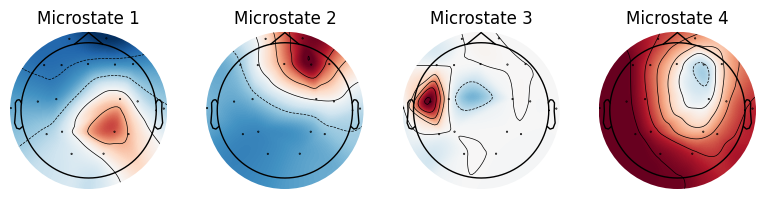

In [9]:
# visualize the maps.
from snn_lib.plots.microstate_plot import plot_maps
eeg_raw.rename_channels({ch_name: ch_name.replace("EEG ", "").replace("-Ref", "") for ch_name in eeg_raw.info['ch_names']})

eeg_raw.set_montage("standard_1020")
plot_maps(microstate_maps, eeg_raw.info, False)


In [10]:
import matplotlib.pyplot as plt
def plot_microstates(eeg_data, microstate_sequence, freq = 256, time_step_offsets = 0):
     color_map = {
        0: '#00FFFF',
        1: '#FF007F',
        2: '#00CC00',
        3: '#6666FF',
     }
     color_sequence = [color_map[m_id] for m_id in microstate_sequence]
     time_steps = eeg_data.shape[0]
     channels = eeg_data.shape[1]
     dt = 1 / freq
     t = np.arange(eeg_data.shape[0]) * dt
     time_duration = time_steps * dt
     plt.figure(figsize=(10, 8))
     for i in range(channels):
        plt.plot(t + time_step_offsets * dt, eeg_data[:, i] + 0.00015 * (i + 2), markersize=2)
        plt.xlabel('Time (s)')
        plt.ylabel('Channels')

        plt.xlim(time_step_offsets * dt, time_step_offsets * dt + time_duration)
        plt.ylim(0.0, 0.002)
     plt.yticks(np.arange(0, 0.00375, 0.0001))
     plt.plot(t + time_step_offsets * dt, eeg_data[:, i] + 0.00015 * (i + 2), markersize=2)
     for index, _t in enumerate(t):
         plt.vlines(x=_t, ymin = 0, ymax = 0.00013, color = color_sequence[index])
         # plt.scatter(t + time_step_offsets * dt, [[0.0001]] * time_steps, c = color_sequence, s=1, marker = 's')

     

## Frequency Curve Construction

In [11]:
import matplotlib.pyplot as plt

In [12]:
# def calculate frequency density
def generate_frequency_density(eeg_data, seizure_onset_annotations, sampling_frequency = 256, \
                               left_decay_coefficiency = 0.4, right_decay_coefficiency = 0.4):
    time_steps = eeg_data.shape[0]
    frequency_density = np.zeros((time_steps))
    for seizure_onset_annotation in seizure_onset_annotations:
        seizure_onset_start_time_step = seizure_onset_annotation[0]
        seizure_onset_end_time_step = seizure_onset_annotation[1]
        frequency_density[seizure_onset_start_time_step: seizure_onset_end_time_step] = sampling_frequency
        time_step = seizure_onset_start_time_step
        while time_step >= 0:
            abs_delta = seizure_onset_start_time_step - time_step
            freq = np.exp(-1 * left_decay_coefficiency * (abs_delta / sampling_frequency)) * sampling_frequency
            frequency_density[time_step] = freq
            time_step -= 1

        time_step = seizure_onset_end_time_step
        while time_step < time_steps:
            abs_delta = time_step - seizure_onset_end_time_step
            freq = np.exp(-1 * right_decay_coefficiency * (abs_delta / sampling_frequency)) * sampling_frequency
            frequency_density[time_step] = freq
            time_step += 1
            
    return frequency_density

def calculate_spike_frequency_distribution_by_sliding_window(spikes_series, windows_size = 256, sampling_frequency = 256):
    time_steps = len(spikes_series)
    frequency_distribution = np.zeros((time_steps))
    cnt_spikes_in_windows = 0
    for t in range(time_steps):
        cnt_spikes_in_windows += spikes_series[t]
        if t < windows_size:
            freq = cnt_spikes_in_windows / windows_size
            frequency_distribution[t] = freq
            continue
        cnt_spikes_in_windows -= spikes_series[t - windows_size]
        freq = cnt_spikes_in_windows / windows_size
        frequency_distribution[t] = freq
        
    return frequency_distribution * sampling_frequency

def plot_frequency_density(frequency_density_data, sampling_frequency = 256):
    time_steps = frequency_density_data.shape[0]
    plt.plot(np.arange(0, time_steps) / sampling_frequency, frequency_density_data)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Temporal Frequency Distribution")


In [13]:
sampling_freq = 500

target_frequency_density_data = generate_frequency_density(train_data, [(seizure_offset, seizure_offset + seizure1_length)], sampling_frequency = sampling_freq)

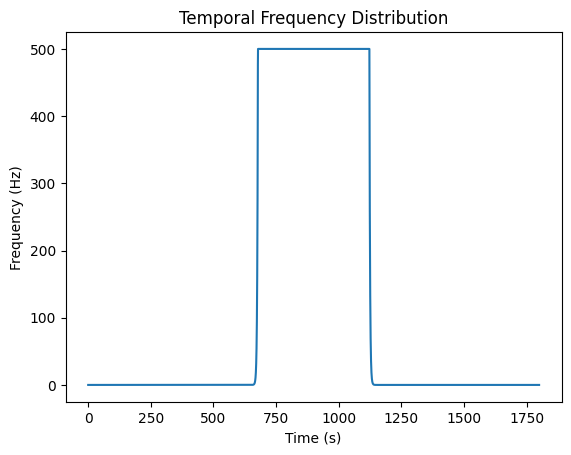

In [14]:
plot_frequency_density(target_frequency_density_data, sampling_frequency = sampling_freq)

## Spike Encoding

In [15]:
import matplotlib.pyplot as plt

In [16]:
cnt_microstates = 4

In [17]:
a = (train_data.dot(microstate_maps.T)) ** 2

In [18]:
microstate_sequence = np.argmax(a, axis = 1)

In [19]:
spikes = np.zeros((len(microstate_sequence), cnt_microstates))
for i in range(cnt_microstates):
    spikes[microstate_sequence == i, i] = 1

## Network Building

In [20]:
from snn_lib.neuron_models.leaky_intergrate_and_fire_model import *
from snn_lib.synapse_models.delay_connection import *

from snn_lib.synapse_models.exponential_synapse import *
from snn_lib.neuron_models.point_process_model import *
from snn_lib.connections.full_connection import *
from snn_lib.connections.possibility_connection import *
from snn_lib.connections.all_to_all_connection import *

from snn_lib.connections.one_to_one_connection import OneToOneConnection
from snn_lib.neuron_models.fixed_spike_train_neuron_model import FixedSpikeTrainNeuronModel
from snn_lib.monitors.neuron_monitors import NeuronOutputMonitor, NeuronMembranePotentialMonitor
from snn_lib.monitors.synapse_monitors import *
from snn_lib.monitors.network_recorder_manager import NetworkRecorderManager
from snn_lib.network.network_builder import NetworkBuilder
import numpy as np

from tqdm import tqdm

In [21]:
network_builder = NetworkBuilder()

### Build reservoir network (Population version)

In [22]:
weights = {item[0] + "_" + item[1]: item for item in np.load("./dataset/weights.npy")}
input_weights = np.zeros((39, 4))
for i in range(0, 4):
    input_weights[i, i] = float(weights[f'input{i}_r{i}'][2])
reservoir_weights = np.zeros((39, 39))
for i in range(0, 39):
    for j in range(0, 39):
        key = f"r{i}_r{j}"
        if key in weights:
            reservoir_weights[j, i] = float(weights[key][2])
output_weights = np.zeros((1, 39))
for i in range(0, 39):        
    key = f"r{i}_output"
    if key in weights:
        output_weights[0, i] = float(weights[key][2])

reservoir_weights_mask = np.zeros((39, 39))
reservoir_weights_mask[reservoir_weights != 0] = 1


In [23]:
n_reservior_neurons = 39
freq = 500
n_microstates = cnt_microstates
dt = 1 / freq
connection_possibility = 0.2
time_steps = len(microstate_sequence)
dummy_spikes = spikes # np.random.randint(0, 2, size=(n_microstates, int(time_steps)))

# Generate input neurons
input_neuron = network_builder.add_neuron(f'input', FixedSpikeTrainNeuronModel(N = n_microstates, spikes = dummy_spikes, hyperparameters = {'dt': dt}))

# Generate reservoir neurons
reservoir_neuron = network_builder.add_neuron(f'reservoir', CurrentBasedLIFNeuron(n_reservior_neurons, {'dt': dt}))

# Generate output neurons
output_neuron = network_builder.add_neuron('output', CurrentBasedLIFNeuron(1, {'dt': dt}))

# Connection: inner reservoir.
# network_builder.add_connection((f'reservoir', f'reservoir', PossibilityConnection(reservoir_neuron, reservoir_neuron, connection_possibility, weights = reservoir_weights), \
#                                 DoubleExponentialSynapse(pre_N = 39, post_N = 39, dt = dt, td = 1e-2, tr = 5e-3)))

network_builder.add_connection((f'reservoir', f'reservoir', CustomAllToAllConnection(reservoir_neuron, reservoir_neuron, connection_possibility, weights = reservoir_weights, mask = reservoir_weights_mask), \
                                DoubleExponentialSynapse(pre_N = 39, post_N = 39, dt = dt, td = 1e-2, tr = 5e-3)))
# Connection: reservoir -> output.
network_builder.add_connection((f'reservoir', f'output', AllToAllConnection(reservoir_neuron, output_neuron, weights = output_weights), DoubleExponentialSynapse(39, 1,  dt = dt, td = 1e-2, tr = 5e-3)))

# Connection: input -> reservoir.
network_builder.add_connection((f'input', f'reservoir', CustomOneToOneConnection(input_neuron, reservoir_neuron, [0, 1, 2, 3], [0, 1, 2, 3], weights = input_weights), DoubleExponentialSynapse(4, 39, dt = dt, td = 1e-2, tr = 5e-3)))


def sigmoid(x):
  try:
      exp_x = np.exp(-x)
  except OverflowError:
      print(-x)
  return 1 / (1 + exp_x)

def derivative_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))
network = network_builder.build_network()
network.initialize_network()

# ------------------------------------------- Begin Build records -------------------------------------------
def recalculate_spikes_in_window(t, recorder, neuron, neuron_id, current_record):
    new_value = current_record + recorder.get_neuron_recorder("neuron_spike_series")[neuron_id][t]
    
    if t < windows_size:
        return new_value
    else:
        new_value -= recorder.get_neuron_recorder('neuron_spike_series')[neuron_id][t - windows_size]
        return new_value

def part_S_c_i_part_w_ij(t, recorder, connection, current_record):
    if connection[0] != 'reservoir' or connection[1] != 'output':
        return []
    pre_neuron = recorder.neuron_map[connection[0]]
    new_record = current_record + [np.zeros(pre_neuron.n_neuron)]
    if t < 0:
        raise ValueError
    if t == 0:
        return new_record
    if t > 0 and t <= windows_size:
        syapse_output_from_pre_neuron = connection[3]._states[connection[3]._output_index]
        post_neuron_id = connection[1]

        # post_neuron_potential need divide 1000, converting from mV to V.
        post_neuron_potential = recorder.get_neuron_recorder('neuron_mebrance_potential')[post_neuron_id][t] / 1000
        new_record[-1] = new_record[t - 1] + sigmoid(post_neuron_potential / 1000) * syapse_output_from_pre_neuron
        return new_record
    if t > windows_size:
        syapse_output_from_pre_neuron = connection[3]._states[connection[3]._output_index]
        post_neuron_id = connection[1]
        post_neuron_potential = recorder.get_neuron_recorder('neuron_mebrance_potential')[post_neuron_id][t]
        new_record[-1] = new_record[t - 1] + sigmoid(post_neuron_potential / 1000) * (syapse_output_from_pre_neuron - new_record[t - windows_size])
        return new_record
    
train_recorder = NetworkRecorderManager(network.neurons, network.connections)
windows_size = 500
train_recorder.add_neuron_recorder('neuron_spike_series',  lambda : [], \
                                   lambda t, recorder, neuron, neuron_id, current_record, arg: current_record + [neuron._states[neuron._output_index]])
train_recorder.add_neuron_recorder('neuron_freq_series', lambda : [], \
                                   lambda t, recorder, neuron, neuron_id, current_record, arg: current_record + [recorder.get_neuron_recorder('cnt_spikes_in_window_record')[neuron_id] / windows_size])
train_recorder.add_neuron_recorder('neuron_mebrance_potential', lambda : [], \
                                   lambda t, recorder, neuron, neuron_id, current_record, arg: current_record + [neuron._states[neuron.INDEX_V]])
train_recorder.add_connection_recorder('connection_history_weights', lambda : [], \
                                   lambda t, recorder, connection, current_record, arg: current_record + [connection[2].W])
train_recorder.add_neuron_recorder('cnt_spikes_in_window_record', lambda : 0, \
                                   lambda t, recorder, neuron, neuron_id, current_record, arg: recalculate_spikes_in_window(t, recorder, neuron, neuron_id, current_record))

train_recorder.add_connection_recorder('part_S_c-i_part_w_ij', lambda: [], \
                                   lambda t, recorder, connection, current_record, arg: part_S_c_i_part_w_ij(t, recorder, connection, current_record))

train_recorder.add_pre_requisite(record="cnt_spikes_in_window_record", requisite=[(NetworkRecorderManager.NEURON_RECORD, 'neuron_spike_series')])
train_recorder.add_pre_requisite(record="neuron_freq_series", requisite=[(NetworkRecorderManager.NEURON_RECORD, 'cnt_spikes_in_window_record')])
train_recorder.add_pre_requisite(record="part_S_c-i_part_w_ij", \
                                 requisite=[(NetworkRecorderManager.NEURON_RECORD, 'neuron_mebrance_potential'), \
                                            (NetworkRecorderManager.NEURON_RECORD, 'neuron_spike_series'), \
                                            (NetworkRecorderManager.CONNECTION_RECORD, 'connection_history_weights')
                                           ])

                                   
train_recorder.initialize_recorders()
# ------------------------------------------- End Build records -------------------------------------------


In [24]:
cost = 0
r = 0.01 # learning rate
train_connections = []
for connection in network.connections:
    if(connection[0].startswith('r') and connection[1] == 'output'):
        train_connections.append(connection)

part_s_c_i_part_w_recorder = train_recorder.get_connection_recorder('part_S_c-i_part_w_ij')
frequency_output_recorder = train_recorder.get_neuron_recorder('neuron_freq_series')

time_steps = 2000
for t in tqdm(range(time_steps)):
        network.forward_single_time_step(t, train_recorder)
        # update weights
        # 1. retrieve necessary records.\n",
        frequency_output = frequency_output_recorder['output'][t]
        # for connection in train_connections:
        #     # print(part_s_c_i_part_w_recorder[connection[0] + '_output'],connection[0] + '_output')
        #     part_s_c_i_part_w_record = part_s_c_i_part_w_recorder[connection[0] + '_output'][t]
        #     part_F_part_w = (1 / windows_size) * part_s_c_i_part_w_record
        #     freq_diff = frequency_output - target_frequency_density_data[t] / freq
        #     surrogate_gradient = (freq_diff * part_F_part_w).clip(50) # gradient clip
            # update weight
            # if (surrogate_gradient != 0):
            #     #print(\"update [%s], W += \" % (connection[0] + '_output'), r * surrogate_gradient)\n",
            #     connection[2].W += r * surrogate_gradient
        cost += 0.5 * (frequency_output - target_frequency_density_data[t] / freq) ** 2
print("End of an epoch, cost = %lf" % (cost))

  4%|████▊                                                                                                      | 89/2000 [00:00<00:02, 882.47it/s]

neuron <snn_lib.neuron_models.fixed_spike_train_neuron_model.FixedSpikeTrainNeuronModel object at 0x000001A76BEFAAF0> update state to [array([0., 0., 0., 1.]), 1, 0]
neuron <snn_lib.neuron_models.leaky_intergrate_and_fire_model.CurrentBasedLIFNeuron object at 0x000001A76BEFAA30> update state to [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([-60., -60., -60., -60., -60., -60., -60., -60., -60., -60., -60.,
       -60., -60., -60., -60., -60., -60., -60., -60., -60., -60., -60.,
       -60., -60., -60., -60., -60., -60., -60., -60., -60., -60., -60.,
       -60., -60., -60., -60., -60., -60.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.]), 1, array([-60., -60., -60., -60., -60., -60., -60., -60., -60., -60., -60.,
       -60., -60., -60., -60., -60., -60., -60., -6

 13%|█████████████▊                                                                                            | 260/2000 [00:00<00:02, 782.56it/s]

neuron <snn_lib.neuron_models.fixed_spike_train_neuron_model.FixedSpikeTrainNeuronModel object at 0x000001A76BEFAAF0> update state to [array([0., 0., 0., 1.]), 162, 0]
neuron <snn_lib.neuron_models.leaky_intergrate_and_fire_model.CurrentBasedLIFNeuron object at 0x000001A76BEFAA30> update state to [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([-60.        , -59.99990837, -59.99963532, -60.        ,
       -60.        , -60.        , -60.        , -60.        ,
       -54.16639526, -52.19719617, -60.        , -60.        ,
       -52.34107659, -60.        , -59.37696211, -52.53812547,
       -56.49124844, -57.81603337, -60.        , -60.        ,
       -60.        , -60.        , -58.15607487, -52.93594261,
       -60.        , -52.78060971, -60.        , -60.        ,
       -60.        , -60.        , -57.81915618, -58.82967022,
       -52.62999721, -54.76539116, -60.        , -60.        ,
 

 21%|██████████████████████▎                                                                                   | 421/2000 [00:00<00:02, 756.17it/s]

neuron <snn_lib.neuron_models.fixed_spike_train_neuron_model.FixedSpikeTrainNeuronModel object at 0x000001A76BEFAAF0> update state to [array([0., 0., 0., 1.]), 311, 0]
neuron <snn_lib.neuron_models.leaky_intergrate_and_fire_model.CurrentBasedLIFNeuron object at 0x000001A76BEFAA30> update state to [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([-59.71647132, -59.98128653, -59.7960359 , -53.07329857,
       -59.99999492, -59.99996834, -59.99504484, -59.88457286,
       -54.51966194, -52.66971199, -59.92119057, -59.99999132,
       -52.69540268, -60.        , -59.55031806, -52.81863906,
       -56.70372855, -58.24190685, -59.99816753, -59.93811949,
       -60.        , -60.        , -58.6691342 , -53.20797434,
       -59.9805219 , -54.21004995, -60.        , -60.        ,
       -59.99993733, -60.        , -58.42596078, -59.15530633,
       -53.07630383, -55.06808327, -59.99979322, -60.        ,
 

 30%|███████████████████████████████▎                                                                          | 590/2000 [00:00<00:01, 789.87it/s]

neuron <snn_lib.neuron_models.fixed_spike_train_neuron_model.FixedSpikeTrainNeuronModel object at 0x000001A76BEFAAF0> update state to [array([0., 1., 0., 0.]), 486, 0]
neuron <snn_lib.neuron_models.leaky_intergrate_and_fire_model.CurrentBasedLIFNeuron object at 0x000001A76BEFAA30> update state to [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([-53.16812826, -59.90981617, -59.99589058, -51.40306796,
       -59.99953369, -59.99878211, -59.99958236, -57.71063828,
       -55.74972987, -54.31459735, -58.43690755, -59.99966623,
       -52.24044765, -59.99942096, -59.54482529, -51.12977702,
       -57.44406678, -55.18251299, -59.9997061 , -58.7622069 ,
       -59.99997535, -59.99789977, -58.65126204, -51.76347726,
       -59.99738662, -54.72836822, -60.        , -59.99668503,
       -59.99583741, -59.99085332, -58.40673421, -59.14415416,
       -54.63160898, -56.18091223, -59.99819484, -60.        ,
 

 38%|████████████████████████████████████████▍                                                                 | 763/2000 [00:00<00:01, 827.61it/s]

neuron <snn_lib.neuron_models.fixed_spike_train_neuron_model.FixedSpikeTrainNeuronModel object at 0x000001A76BEFAAF0> update state to [array([0., 0., 1., 0.]), 664, 0]
neuron <snn_lib.neuron_models.leaky_intergrate_and_fire_model.CurrentBasedLIFNeuron object at 0x000001A76BEFAA30> update state to [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([-52.27485688, -59.77089985, -60.        , -51.60865524,
       -60.        , -60.        , -60.        , -58.67110761,
       -55.43876535, -53.89906913, -59.09268088, -60.        ,
       -52.75118118, -60.        , -59.77397879, -52.17193398,
       -57.25654378, -57.33935586, -60.        , -59.28758052,
       -60.        , -60.        , -59.3310741 , -52.68359144,
       -60.        , -56.26564945, -60.        , -60.        ,
       -60.        , -60.        , -59.20884916, -59.57543618,
       -54.23747175, -55.90711399, -60.        , -60.        ,
 

 46%|█████████████████████████████████████████████████▎                                                        | 930/2000 [00:01<00:01, 795.63it/s]

neuron <snn_lib.neuron_models.fixed_spike_train_neuron_model.FixedSpikeTrainNeuronModel object at 0x000001A76BEFAAF0> update state to [array([0., 0., 0., 1.]), 846, 0]
neuron <snn_lib.neuron_models.leaky_intergrate_and_fire_model.CurrentBasedLIFNeuron object at 0x000001A76BEFAA30> update state to [array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([-59.99999998, -59.99979046, -59.99999999, -60.        ,
       -60.        , -60.        , -60.        , -59.99999996,
       -54.14083294, -52.16300505, -59.99999997, -60.        ,
       -52.30751586, -59.99999997, -59.3401753 , -52.50542822,
       -56.47587343, -57.68708257, -60.        , -59.99999994,
       -60.        , -60.        , -58.04720168, -52.90498856,
       -59.99999995, -52.49981341, -60.        , -59.99999996,
       -60.        , -59.99999995, -57.69038987, -58.76056892,
       -52.59770259, -54.74245358, -60.        , -60.        ,
 

 54%|█████████████████████████████████████████████████████████                                                | 1087/2000 [00:01<00:01, 640.82it/s]

neuron <snn_lib.neuron_models.fixed_spike_train_neuron_model.FixedSpikeTrainNeuronModel object at 0x000001A76BEFAAF0> update state to [array([0., 0., 0., 1.]), 1005, 0]
neuron <snn_lib.neuron_models.leaky_intergrate_and_fire_model.CurrentBasedLIFNeuron object at 0x000001A76BEFAA30> update state to [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([-59.83765472, -59.20925025, -59.97290834, -60.        ,
       -59.89893942, -60.        , -59.78979642, -59.91199841,
       -54.26000223, -52.25338244, -59.93991573, -60.        ,
       -52.29815386, -60.        , -59.38122496, -52.54036299,
       -56.50278811, -56.8982982 , -59.92226431, -59.88685638,
       -60.        , -60.        , -58.16869108, -52.9490735 ,
       -59.1737165 , -52.85449905, -60.        , -60.        ,
       -59.90299378, -59.91998177, -57.8340776 , -58.83767766,
       -52.74825748, -54.24271887, -59.99122801, -60.        ,


 61%|████████████████████████████████████████████████████████████████▍                                        | 1228/2000 [00:01<00:01, 639.97it/s]

neuron <snn_lib.neuron_models.fixed_spike_train_neuron_model.FixedSpikeTrainNeuronModel object at 0x000001A76BEFAAF0> update state to [array([0., 0., 0., 1.]), 1097, 0]
neuron <snn_lib.neuron_models.leaky_intergrate_and_fire_model.CurrentBasedLIFNeuron object at 0x000001A76BEFAA30> update state to [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([-59.99885718, -59.99427421, -60.        , -53.05501969,
       -60.        , -60.        , -60.        , -60.        ,
       -54.22984484, -52.28206387, -60.        , -60.        ,
       -52.42437937, -60.        , -59.51393041, -52.61928504,
       -56.5294116 , -58.29615536, -60.        , -60.        ,
       -60.        , -60.        , -58.56144234, -53.01277529,
       -59.99999999, -53.81162515, -60.        , -60.        ,
       -60.        , -60.        , -58.29859166, -59.08695486,
       -52.71015753, -54.82232572, -60.        , -60.        ,


 65%|███████████████████████████████████████████████████████████████████▉                                     | 1295/2000 [00:01<00:01, 611.68it/s]

neuron <snn_lib.neuron_models.fixed_spike_train_neuron_model.FixedSpikeTrainNeuronModel object at 0x000001A76BEFAAF0> update state to [array([0., 0., 0., 1.]), 1229, 0]
neuron <snn_lib.neuron_models.leaky_intergrate_and_fire_model.CurrentBasedLIFNeuron object at 0x000001A76BEFAA30> update state to [array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([-59.99739631, -59.49039952, -59.99996241, -60.        ,
       -60.        , -60.        , -59.99916866, -59.9989312 ,
       -54.29734108, -52.37234423, -59.99927026, -60.        ,
       -52.51198129, -60.        , -59.57900683, -52.7042413 ,
       -56.57000872, -58.51949436, -59.99969256, -59.99942702,
       -60.        , -60.        , -58.75404066, -53.09306602,
       -59.99673212, -54.31852004, -60.        , -60.        ,
       -60.        , -60.        , -58.52638121, -59.20919603,
       -52.79543027, -54.88049212, -59.99996531, -60.        ,


 71%|██████████████████████████████████████████████████████████████████████████▊                              | 1425/2000 [00:02<00:01, 558.82it/s]

neuron <snn_lib.neuron_models.fixed_spike_train_neuron_model.FixedSpikeTrainNeuronModel object at 0x000001A76BEFAAF0> update state to [array([0., 0., 0., 1.]), 1322, 0]
neuron <snn_lib.neuron_models.leaky_intergrate_and_fire_model.CurrentBasedLIFNeuron object at 0x000001A76BEFAA30> update state to [array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]), array([-58.65852853, -56.61715828, -59.40329877, -60.        ,
       -59.22611706, -60.        , -59.08004343, -58.18504976,
       -51.27132922, -52.56511969, -58.76081836, -60.        ,
       -51.65146194, -57.63855281, -59.51179435, -51.23844873,
       -56.55259425, -56.826678  , -59.66744544, -57.27281392,
       -59.98009804, -60.        , -58.58677042, -51.57819091,
       -53.96321745, -51.63087676, -60.        , -57.04948556,
       -59.26428458, -57.88190261, -58.35875922, -55.74420304,
       -53.4719313 , -50.19732407, -59.9624733 , -59.99243384,


 78%|██████████████████████████████████████████████████████████████████████████████████▎                      | 1569/2000 [00:02<00:00, 609.81it/s]

neuron <snn_lib.neuron_models.fixed_spike_train_neuron_model.FixedSpikeTrainNeuronModel object at 0x000001A76BEFAAF0> update state to [array([0., 0., 0., 1.]), 1426, 0]
neuron <snn_lib.neuron_models.leaky_intergrate_and_fire_model.CurrentBasedLIFNeuron object at 0x000001A76BEFAA30> update state to [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([-59.95808118, -59.99996755, -60.        , -60.        ,
       -60.        , -60.        , -60.        , -59.99952803,
       -54.17472986, -52.20834421, -59.99967776, -60.        ,
       -52.35157142, -60.        , -59.39589794, -52.54807834,
       -56.49626147, -57.88174653, -60.        , -59.99974697,
       -60.        , -60.        , -58.21211682, -52.94539835,
       -59.99999999, -52.92294783, -60.        , -59.99999999,
       -60.        , -59.99999999, -57.88543801, -58.86523975,
       -52.6405269 , -54.77286996, -60.        , -60.        ,


 85%|█████████████████████████████████████████████████████████████████████████████████████████▋               | 1708/2000 [00:02<00:00, 637.70it/s]

neuron <snn_lib.neuron_models.fixed_spike_train_neuron_model.FixedSpikeTrainNeuronModel object at 0x000001A76BEFAAF0> update state to [array([0., 0., 0., 1.]), 1570, 0]
neuron <snn_lib.neuron_models.leaky_intergrate_and_fire_model.CurrentBasedLIFNeuron object at 0x000001A76BEFAA30> update state to [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([-58.71707942, -56.61047633, -60.        , -60.        ,
       -59.99145075, -59.94669465, -59.99997421, -59.9999607 ,
       -58.80030399, -58.39533306, -59.99997317, -59.98539151,
       -58.42488517, -60.        , -59.99999907, -58.46539198,
       -59.2784161 , -59.9998399 , -59.99999046, -59.99997893,
       -60.        , -60.        , -59.99999724, -58.54720516,
       -59.99989861, -59.45271118, -60.        , -60.        ,
       -59.89447231, -60.        , -59.99999673, -59.99999825,
       -58.48433972, -58.92341462, -59.99999892, -60.        ,


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1844/2000 [00:02<00:00, 658.84it/s]

neuron <snn_lib.neuron_models.fixed_spike_train_neuron_model.FixedSpikeTrainNeuronModel object at 0x000001A76BEFAAF0> update state to [array([0., 0., 0., 1.]), 1709, 0]
neuron <snn_lib.neuron_models.leaky_intergrate_and_fire_model.CurrentBasedLIFNeuron object at 0x000001A76BEFAA30> update state to [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([-59.6415928 , -59.43527533, -60.        , -60.        ,
       -60.        , -60.        , -59.91783509, -59.59101588,
       -55.00182515, -53.31463484, -59.7207606 , -60.        ,
       -52.57765953, -60.        , -59.59188555, -53.03905588,
       -56.99373636, -57.83057084, -59.96961447, -59.40238911,
       -60.        , -60.        , -58.79215614, -53.39573665,
       -59.6770202 , -54.73411601, -60.        , -60.        ,
       -60.        , -59.5410473 , -58.57146108, -59.23338772,
       -53.6854545 , -55.27790311, -59.99657118, -60.        ,


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1979/2000 [00:02<00:00, 655.93it/s]

neuron <snn_lib.neuron_models.fixed_spike_train_neuron_model.FixedSpikeTrainNeuronModel object at 0x000001A76BEFAAF0> update state to [array([0., 0., 0., 1.]), 1845, 0]
neuron <snn_lib.neuron_models.leaky_intergrate_and_fire_model.CurrentBasedLIFNeuron object at 0x000001A76BEFAA30> update state to [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([-55.21794336, -59.38673865, -58.26934434, -60.        ,
       -59.99999992, -59.99999952, -59.83754361, -59.81530413,
       -55.55646748, -54.05650295, -59.87389642, -59.99999987,
       -53.99092395, -60.        , -59.64590856, -54.15727797,
       -57.32733835, -57.85931046, -59.93992177, -59.90098451,
       -60.        , -60.        , -58.95204109, -54.37000262,
       -59.36140463, -55.38237143, -60.        , -60.        ,
       -59.99999906, -60.        , -58.76055991, -59.33486588,
       -54.38617313, -55.54386574, -59.99322055, -60.        ,


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 676.74it/s]

neuron <snn_lib.neuron_models.fixed_spike_train_neuron_model.FixedSpikeTrainNeuronModel object at 0x000001A76BEFAAF0> update state to [array([0., 1., 0., 0.]), 1980, 0]
neuron <snn_lib.neuron_models.leaky_intergrate_and_fire_model.CurrentBasedLIFNeuron object at 0x000001A76BEFAA30> update state to [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([-55.78542728, -51.68709803, -59.99772755, -59.00302687,
       -60.        , -60.        , -60.        , -57.17701154,
       -59.52473408, -59.36430271, -58.07256673, -60.        ,
       -56.69856436, -60.        , -59.92865163, -55.15681894,
       -59.71414072, -55.78090941, -60.        , -58.48659531,
       -60.        , -60.        , -59.78883939, -55.61538504,
       -60.        , -59.26120108, -60.        , -60.        ,
       -60.        , -60.        , -59.75025651, -59.86597745,
       -59.39956317, -59.5735345 , -60.        , -60.        ,



C:\Users\Micro\AppData\Local\Temp\ipykernel_5592\2130482454.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("End of an epoch, cost = %lf" % (cost))


In [46]:
train_recorder.neuron_recorders['neuron_spike_series'].record

{'input': [array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0., 1.]),
  array([0., 0., 0.

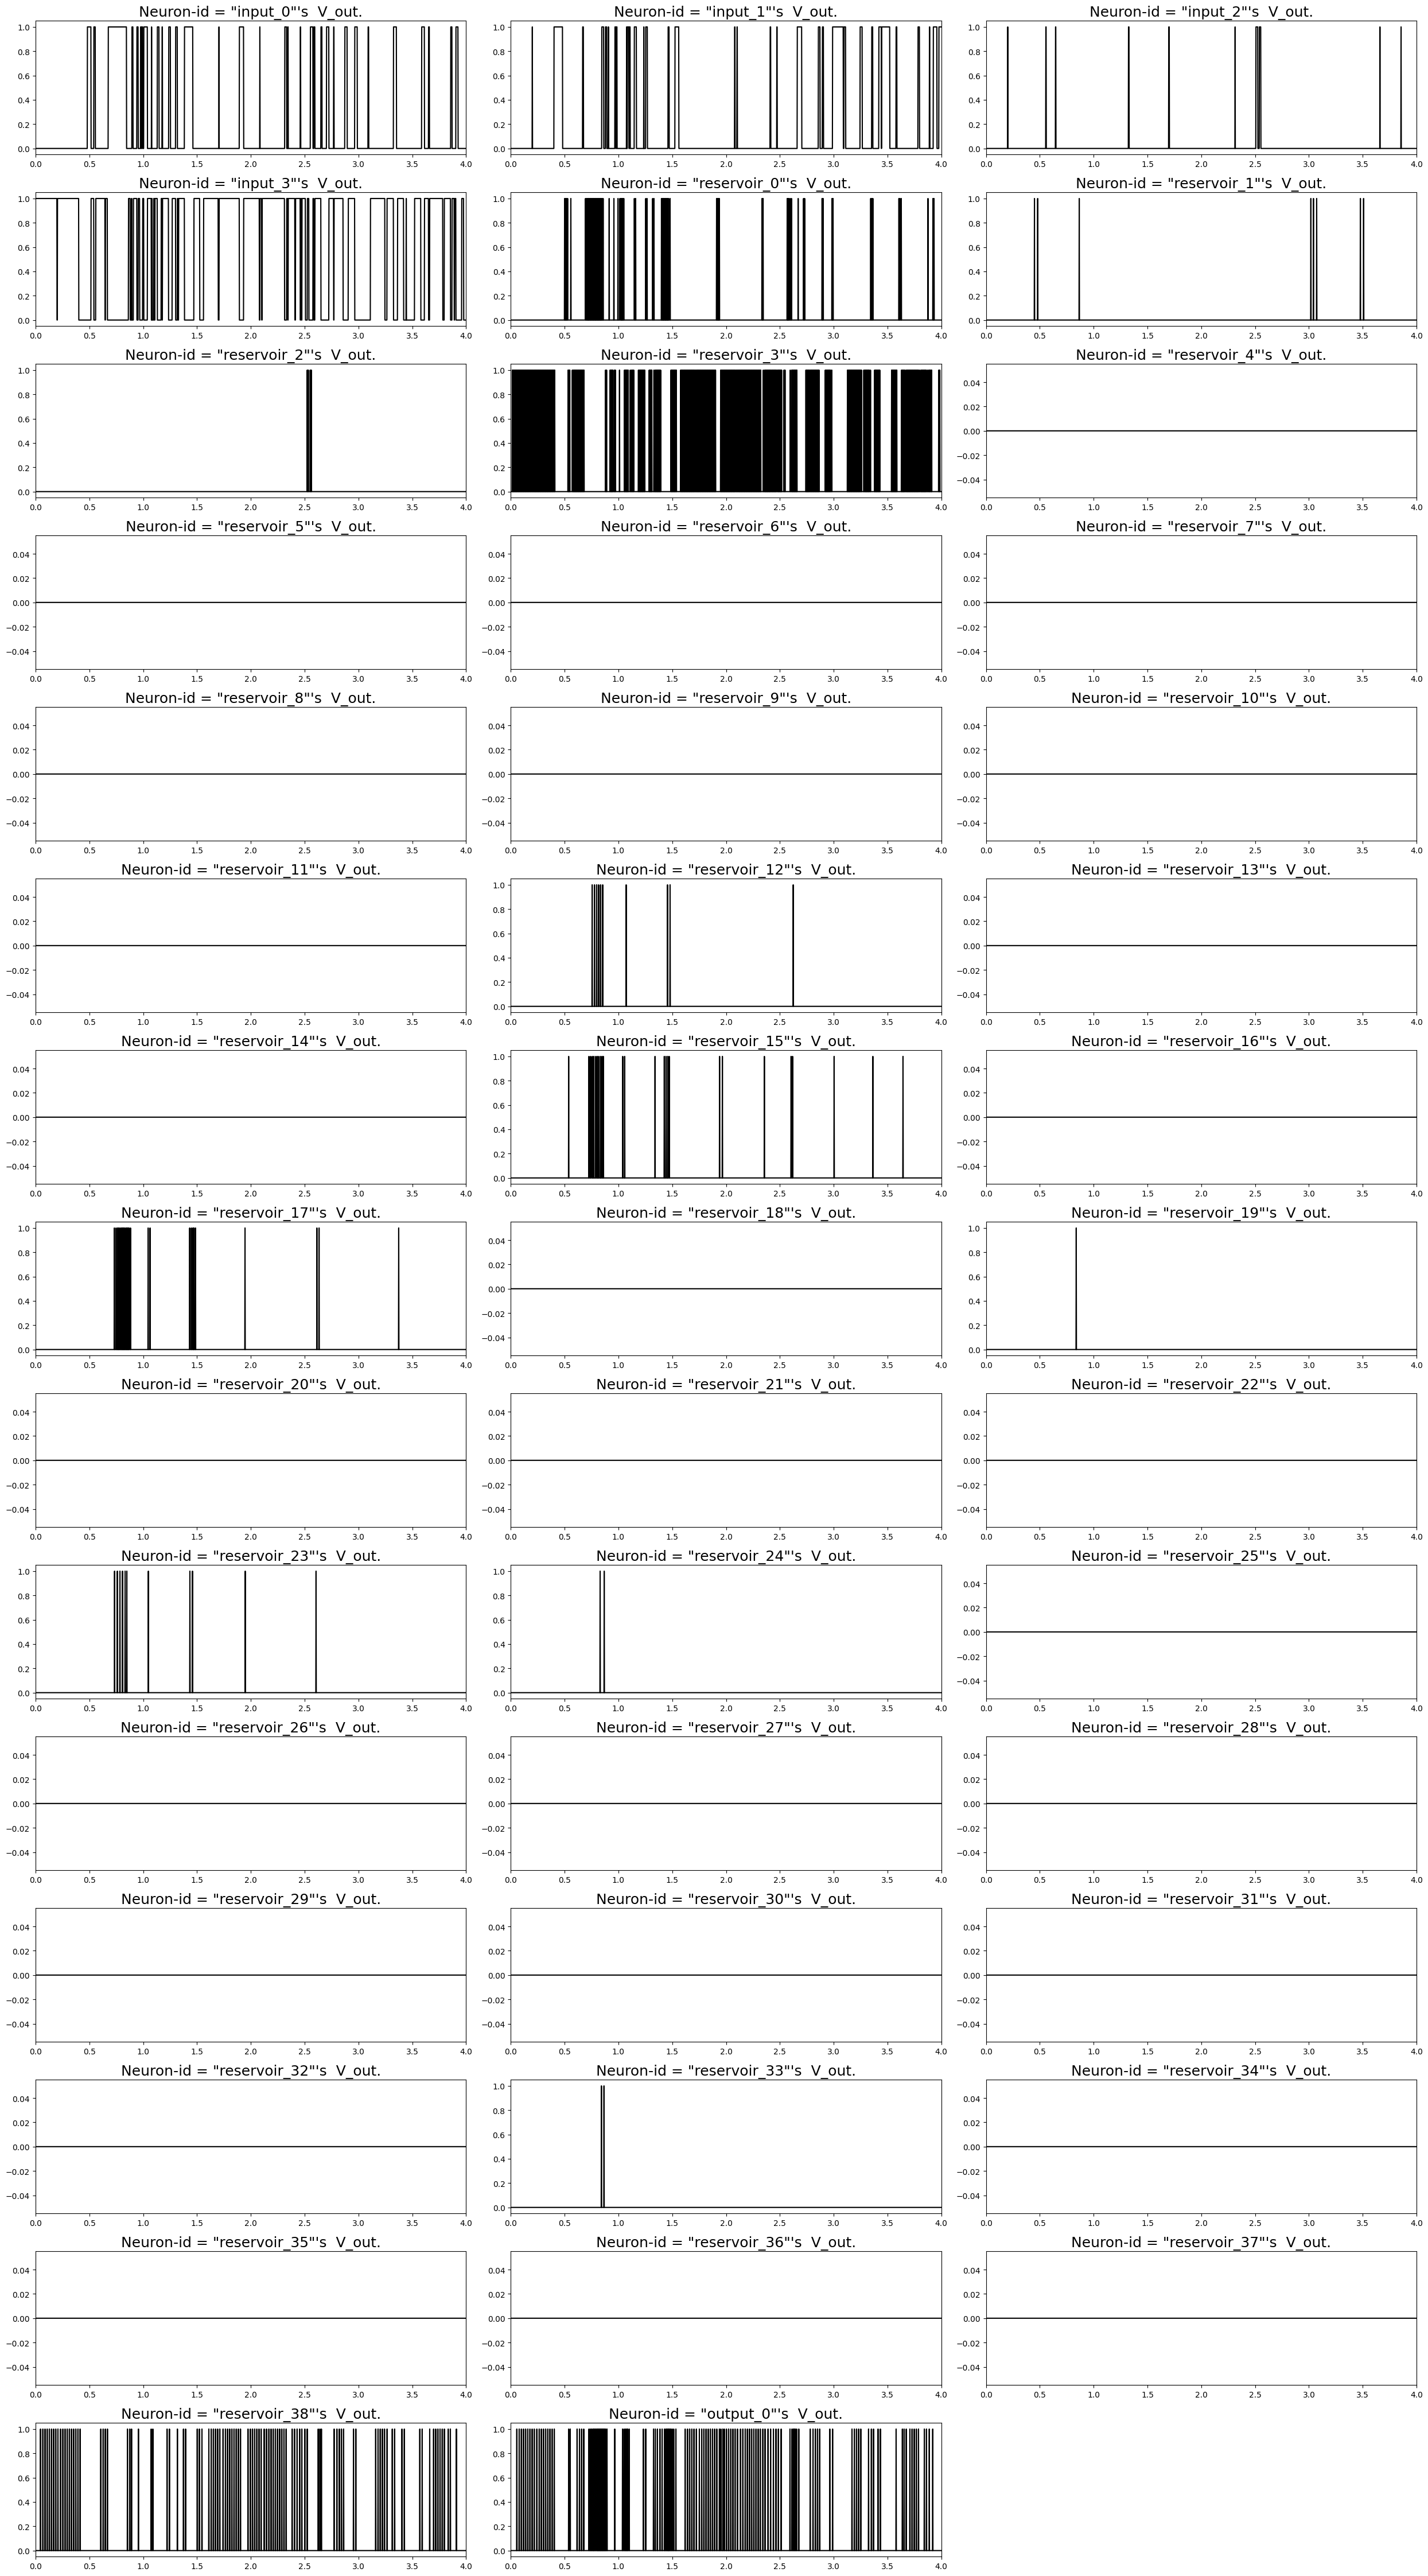

In [25]:
plot_neuron_record(train_recorder, 'neuron_spike_series', lambda record_id, i: 'Neuron-id = "' + record_id + ('_%d' % i) + '"\'s  V_out.', dt = dt)

In [ ]:
plot_neuron_record(train_recorder, 'neuron_mebrance_potential', lambda record_id, i: 'Neuron-id = "' + record_id + ('_%d' % i) + '"\'s  Membrane Potential.', dt=dt)

In [31]:
neuron_output_record = network.neuron_output_monitor.get_dataframe_record()


In [ ]:
import matplotlib.pyplot as plt
import itertools
fig = plt.figure(figsize=(25,45))
rows = int(np.ceil(sum([network.neurons[n].n_neuron for n in network.neurons]) / 3))
cols = 3
current_index = 0
for record_id in neuron_output_record:
    record = (np.array([list(r) if hasattr(r, '__iter__') else [r] for r in neuron_output_record[record_id]]))
    for i in range(record.shape[1]):
        plt.subplot(rows, cols, current_index + 1)
        plt.tight_layout()
    
        plt.plot(np.arange(int(time_steps) + 1)[:time_steps + 1] * dt, record[:, i] , color="k")
        plt.xlim(0, time_steps * dt)
        plt.xlabel('$time$ ($s$)')
        plt.ylabel('$V$ ($mV$)')
        plt.title('Neuron-id = "' + record_id + ('_%d' % i) + '"\'s Output Voltage.', fontsize = 18)
        current_index += 1

In [ ]:
neuron_membrane_potential = network.neuron_membrane_potential_monitor.get_dataframe_record()

In [ ]:
import matplotlib.pyplot as plt
import itertools
fig = plt.figure(figsize=(25,45))
rows = int(np.ceil(sum([network.neurons[n].n_neuron for n in network.neurons]) / 3))
cols = 3
current_index = 0
for record_id in neuron_membrane_potential:
    record = (np.array([list(r) if hasattr(r, '__iter__') else [r] for r in neuron_membrane_potential[record_id]]))
    for i in range(record.shape[1]):
        plt.subplot(rows, cols, current_index + 1)
        plt.tight_layout()
    
        plt.plot(np.arange(int(time_steps) + 1)[:time_steps + 1] * dt, record[:, i] , color="k")
        plt.xlim(0, time_steps * dt)
        plt.xlabel('$time$ ($s$)')
        plt.ylabel('$V$ ($mV$)')
        plt.title('Neuron-id = "' + record_id + ('_%d' % i) + '"\'s  Membrane Potential.', fontsize = 18)
        current_index += 1



In [ ]:
output_spike_train = np.array(neuron_output_record['output'])
output_frequency_distribution = calculate_spike_frequency_distribution_by_sliding_window(output_spike_train, windows_size = 500, sampling_frequency = 500)


In [ ]:
plot_frequency_density(output_frequency_distribution, sampling_frequency = sampling_freq)

In [ ]:
plt.plot(output_spike_train)

In [ ]:
plot_frequency_density(target_frequency_density_data, sampling_frequency = sampling_freq)

In [ ]:

output_spike_train = np.array(neuron_output_record['output'])


In [ ]:
np.zeros((39, 4)).sum(axis=1)

array([[1., 1.]])